# Data Analysis
Write a Jupyter Notebook called AnalyticalWork.ipynb with your answers to the
following exercises/questions.

In [64]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime
from collections import defaultdict
import json
warnings.filterwarnings('ignore')

In [65]:
con = sqlite3.connect(r"../laliga.sqlite")
df = pd.read_sql_query("SELECT * FROM Matches", con)

# Data formatting:
# We split the "date" column into the corresponding columns, and specify the correct formatting.
# This way we avoid the year 29 or higher to be mistaken by 2029 (error with to_datetime function).
df[["month", "day", "year"]] = df["date"].str.split("/", 2, expand = True)
df["year"] = df["year"].apply(lambda x: f"19{x}" if int(x) >= 23 else f"20{x}")
df['datetime'] = pd.to_datetime(df["date"] + ' ' + df["time"])
df['date'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day))
df = df.drop(["month", "day", "year"], axis = 1)

# We also change the formatting of the time to be in 24h format
# df['time'] = df["time"].apply(lambda x: datetime.strftime(datetime.strptime(x, "%I:%M %p"), "%H:%M") if type(x) == str else x)
df.head()

,season,division,matchday,date,time,home_team,away_team,score,datetime
0,1928-1929,1,1,1929-02-10,None,Arenas Club,Athletic Madrid,2:3,NaT
1,1928-1929,1,1,1929-02-10,None,Espanyol,Real Unión,3:2,NaT
2,1928-1929,1,1,1929-02-10,None,Real Madrid,Catalunya,5:0,NaT
3,1928-1929,1,1,1929-02-10,None,Donostia,Athletic,1:1,NaT
4,1928-1929,1,1,1929-02-12,None,Racing,Barcelona,0:2,NaT


1. Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or
there’s a tie) of all matches in the row. Write in the plot the percentage of
each category.

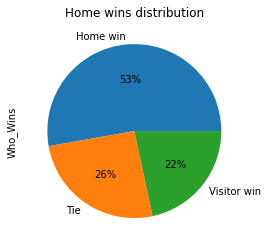

In [66]:
df[["home_goals", "away_goals"]] = df["score"].str.split(":", expand=True).astype(float)
df2=df.dropna(subset="score") 
df2["goal diff"] = (df2["home_goals"]  - df2["away_goals"])
df2["Who_Wins"] = np.where(df2["goal diff"] > 0, "Home win", np.where(df2["goal diff"] < 0, "Visitor win", "Tie"))
home_wins_count = df2["Who_Wins"].value_counts()
ax = home_wins_count.plot(kind = 'pie', autopct = '%1.0f%%')
ax.set_title("Home wins distribution")
plt.show()

As we can see in the plot, the home team is way more likely to win than the visitor team

2. What are the top ten scoring teams of all time? What are the ten teams
that concede the most? Make two bar plot charts showing each of them.
Consider only matches played in 1st division.
What have been the biggest wins? Of course, when we say biggest we mean
those with the highest goal difference. Show the top ten of them in a table.

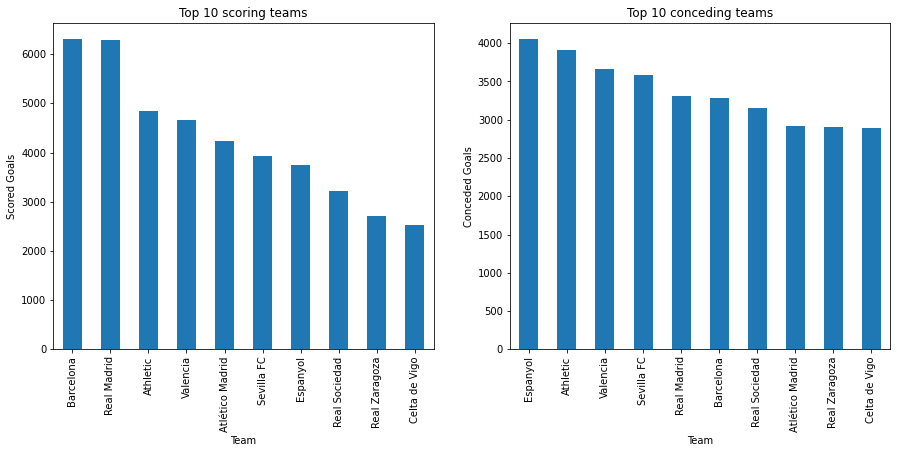

In [68]:
first_division = df2[df2.division == 1]
scored_goals = first_division.pivot_table('home_goals', 'home_team', aggfunc=np.sum)
scored_goals['away_goals'] = first_division.pivot_table('away_goals', 'away_team', aggfunc=np.sum)
scored_goals['total_goals'] = scored_goals['away_goals'] + scored_goals['home_goals']
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
ax = scored_goals['total_goals'].sort_values(ascending=False).head(10).plot(kind='bar')
ax.set_title('Top 10 scoring teams')
ax.set_ylabel('Scored Goals')
ax.set_xlabel('Team')
conceded_goals = first_division.pivot_table('home_goals', 'away_team', aggfunc=np.sum)
conceded_goals['away_goals'] = first_division.pivot_table('away_goals', 'home_team', aggfunc=np.sum)
conceded_goals['total_goals'] = conceded_goals['away_goals'] + conceded_goals['home_goals']
plt.subplot(1, 2, 2)
ax2 = conceded_goals['total_goals'].sort_values(ascending=False).head(10).plot(kind='bar')
ax2.set_title('Top 10 conceding teams')
ax2.set_xlabel('Team')
ax2.set_ylabel('Conceded Goals')
plt.show()

The top 10 scoring teams are: Barcelona, Real Madrid, Athletic, Valencia, Atlético Madrid, Sevilla F C, Espanyol, Real Sociedad, Real Zaragoza and Celta de Vigo.

The top 10 conceding teams are: Espanyol, Athletic, Valencia, Sevilla F C, Real Madrid, Barcelona, Real Sociedad, Atlético Madrid, Real Zaragoza and Celta de Vigo

In [58]:
first_division['abs_diff'] = abs(first_division['goal diff'])
biggest_wins = first_division.sort_values('abs_diff', ascending = False).head(10)
print("Top 10 biggest wins:")
biggest_wins[['season', 'date', 'home_team', 'away_team', 'score', 'goal diff']]

Top 10 biggest wins:


,season,date,home_team,away_team,score,goal diff
225,1930-1931,1931-02-08,Athletic,Barcelona,12:1,11.0
936,1940-1941,1940-09-29,Sevilla FC,Barcelona,11:1,10.0
1168,1941-1942,1942-01-11,Athletic,Celta de Vigo,10:0,10.0
2787,1950-1951,1950-11-19,Athletic,Lérida,10:0,10.0
1071,1941-1942,1941-09-28,Sevilla FC,Real Oviedo,10:0,10.0
2574,1949-1950,1949-10-23,Celta de Vigo,Gimnàstic,10:1,9.0
2771,1950-1951,1950-11-05,Dep. La Coruña,Lérida,10:1,9.0
4745,1958-1959,1958-12-28,Athletic,Real Gijón,9:0,9.0
2969,1951-1952,1951-09-23,Athletic,Real Zaragoza,10:1,9.0
2537,1949-1950,1949-09-11,Barcelona,Gimnàstic,10:1,9.0


3. There has been a lot of discussion about how LaLiga’s television rights have
changed game schedules in the last years. Make a bar plot chart showing
the number of matches played each weekday, and make also a histogram
of match time. Compare this two graphics between seasons 2000-2001 and
2020-2021.

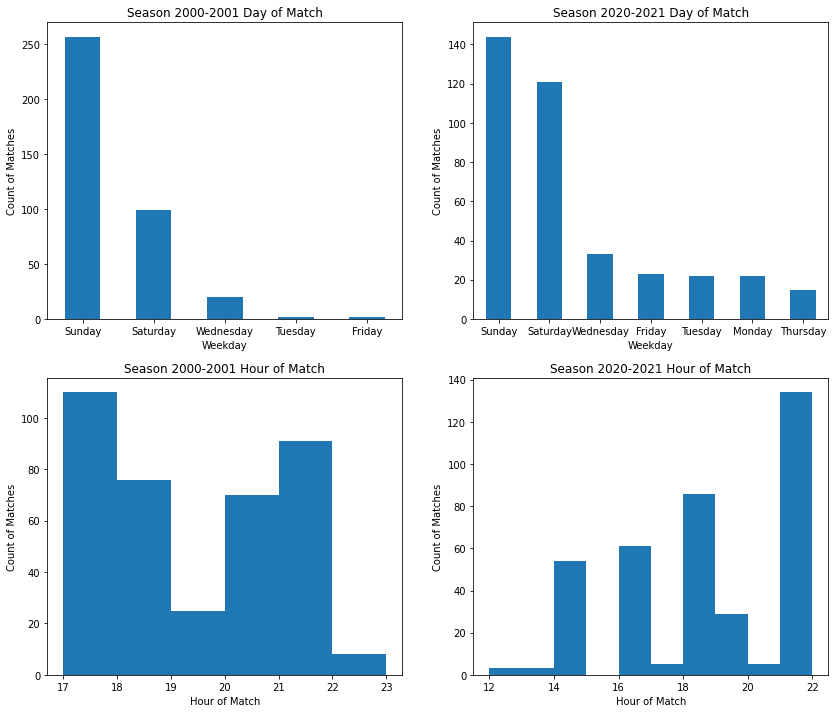

In [70]:
# Check error: AttributeError: Can only use .dt accessor with datetimelike values
# Changes to time formatting! We can keep an original time format column and a stylized one.
season_00_01 = first_division[first_division.season == '2000-2001']
season_00_01['weekday'] = season_00_01['date'].dt.day_name()
season_20_21 = first_division[first_division.season == '2020-2021']
season_20_21['weekday'] = season_20_21['date'].dt.day_name()
plt.figure(figsize=(14,12))
plt.subplot(2,2,1)
season_00_01_plot = season_00_01['weekday'].value_counts().plot(kind = 'bar')
season_00_01_plot.set_title('Season 2000-2001 Day of Match')
season_00_01_plot.set_xlabel('Weekday')
season_00_01_plot.tick_params(axis='x', labelrotation = 0)
season_00_01_plot.set_ylabel('Count of Matches')
plt.subplot(2,2,3)
plt.hist(season_00_01['datetime'].dt.hour, bins = np.arange(17, 24))
plt.title('Season 2000-2001 Hour of Match')
plt.xlabel('Hour of Match')
plt.ylabel('Count of Matches')
plt.subplot(2,2,2)
season_20_21_plot = season_20_21['weekday'].value_counts().plot(kind = 'bar')
season_20_21_plot.set_title('Season 2020-2021 Day of Match')
season_20_21_plot.tick_params(axis='x', labelrotation = 0)
season_20_21_plot.set_xlabel('Weekday')
season_20_21_plot.set_ylabel('Count of Matches')
plt.subplot(2,2,4)
plt.hist(season_20_21['datetime'].dt.hour)
plt.title('Season 2020-2021 Hour of Match')
plt.xlabel('Hour of Match')
plt.ylabel('Count of Matches')
plt.show()

It is clear that both time and day of the match have changed significally. On season 2000-2001 most of the matches were played on Sunday and in a variety of hours that would make matches overlap. Instead, in season 2020-2021 matches are played more or less equally between Saturday and Sunday and more matches are played during workdays. Also, most of the matches are played at 21h and the match schedule is spaced 2h between each match-time.

4. Build a cross results table for season 2020-2021. Figure 1 is an example taken
from Wikipedia. Try to make it the most similar to this one: use team abbreviations as column names and paint the background of each cell according
to result (green in case local team wins and red in case visitor team wins).
Also, could you model the intensity of this background color with the goal
difference from the match?
Write a function that, given the season, plots the cross results table. Function prototype should be like plot_cross_results_table(season) and return the plot object.


In [76]:
def abreviate_names(team_names):
    """Abreviates to 3 letters the name of football teams passed in a list.

    Args:
        team_names (string): string with the name of the teams.

    Returns:
        list(str): 3 letter abreviations for each team.
    """
    abreviations = {}
    for team in team_names:
        words = team.split()
        if words[0] == 'Real':
            abreviations[team] = 'R' + words[1][0:2].upper()
        elif len(words[0])<3:
            abreviations[team] = words[1][0:3].upper()
        else:
            abreviations[team] = words[0][0:3].upper()
    return abreviations

In [77]:
def style_scores(score):
    """Styles values of a dataframe with format 'int:int'. Style format is green if the first integer is greater than the second, red if smaller and yellow if equal. Opacity of each cell is modullated by the difference of the two int.

    Args:
        score (str): result of a match with format 'int:int'. Example: '1:2'

    Returns:
        str: style settings for the cell
    """
    if score == '-': return 'text-align: center'
    else:
        home_goals, away_goals = score.split(":")
        goal_diff = int(home_goals) - int(away_goals)
        if goal_diff < 0:
            return f'background-color:red; opacity: {abs(goal_diff)*20}%; color: white; text-align: center'
        elif goal_diff > 0:
            return f'background-color:green; opacity: {abs(goal_diff)*20}%; text-align: center'
        else:
            return 'background-color:#FFF380; color: black; text-align: center'

In [78]:
def plot_cross_results_table(season):
    """Makes a cross-table showing the results of the input season and league.

    Args:
        season (str): season of the results to make the table from. Format: 'aaaa-aaaa'. Example: '2000-2001'.

    Returns:
        pandas.io.formats.style.Styler: crosstable with the match results.
    """
    df = df2[df2.division == 1]
    df = df[df2.season == season]
    team_names = df.away_team.drop_duplicates()
    df = df.replace({'away_team':abreviate_names(team_names)})
    table = pd.crosstab(df.home_team, df.away_team, rownames=['Home Team'], colnames=['Away Team'], values=df.score, aggfunc='first')
    table = table.fillna('-')
    ordered_columns = abreviate_names(table.index).values()
    table =  table[ordered_columns].style.applymap(style_scores)
    return table
plot_cross_results_table('2010-2011')


Away Team,ATH,ATL,BAR,OSA,DEP,ESP,GET,HÉR,LEV,MÁL,RCD,RAC,RMA,RSO,RZA,SEV,SPO,ALM,VAL,VIL
Home Team,,,,,,,,,,,,,,,,,,,,
Athletic,-,1:2,1:3,1:0,1:2,2:1,3:0,3:0,3:2,1:1,3:0,2:1,0:3,2:1,2:1,2:0,3:0,1:0,1:2,0:1
Atlético Madrid,0:2,-,1:2,3:0,2:0,2:3,2:0,2:1,4:1,0:3,3:0,0:0,1:2,3:0,1:0,2:2,4:0,1:1,1:2,3:1
Barcelona,2:1,3:0,-,2:0,0:0,2:0,2:1,0:2,2:1,4:1,1:1,3:0,5:0,5:0,1:0,5:0,1:0,3:1,2:1,3:1
CA Osasuna,1:2,2:3,0:3,-,0:0,4:0,0:0,3:0,1:1,3:0,1:1,3:1,1:0,3:1,0:0,3:2,1:0,0:0,1:0,1:0
Dep. La Coruña,2:1,0:1,0:4,0:0,-,3:0,2:2,1:0,0:1,3:0,2:1,2:0,0:0,2:1,0:0,3:3,1:1,0:2,0:2,1:0
Espanyol,2:1,2:2,1:5,1:0,2:0,-,3:1,3:0,2:1,1:0,1:2,1:2,0:1,4:1,4:0,2:3,1:0,1:0,2:2,0:1
Getafe,2:2,1:1,1:3,2:0,4:1,1:3,-,3:0,4:1,0:2,3:0,0:1,2:3,0:4,1:1,1:0,3:0,2:0,2:4,1:0
Hércules CF,0:1,4:1,0:3,0:4,1:0,0:0,0:0,-,3:1,4:1,2:2,2:3,1:3,2:1,2:1,2:0,0:0,1:2,1:2,2:2
Levante,1:2,2:0,1:1,2:1,1:2,1:0,2:0,2:1,-,3:1,1:1,3:1,0:0,2:1,1:2,1:4,0:0,1:0,0:1,1:2


See above the cross results table of season 2020-2021. Color green represents home-wins, yellow represents ties and red, home losses. The intensity of the color represents the goal difference.

5. As you surely know, there has always been a historical rivalry between
Barcelona and Real Madrid. But which of them has won the most games
in direct confrontations? Which of them has scored the most goals in these
games? Show both things in two pie charts, side by side. Remember to consider ties in the first one.
Write a function that, given two team names, plots the two graphs described
above. Function prototype should be like plot_direct_confrontations_stats(team1, team2) and return the plot object. Use it with some other
classical rivals like Betis and Sevilla.

In [14]:
def Plot_direct_confrontation_stats(Team1, Team2):
    """Plot two differents graphs, one for direct confrontation results and the other for the scored goals per team
    args:
        Team (str): string with the name of the confrontated teams.
    returns:
        direct_confrontation_count.plot (pie chart) and scored_goals[].sort_values().plot(pie)
    """
    #DIRECT CONFRONTATION RESULTS
    df3 = df2.loc[((df2["home_team"] == Team2) & (df2["away_team"] == Team1)) | ((df2["home_team"] == Team1) & (df2["away_team"] == Team2))]
    df3["Winner"] = np.where(df3["goal diff"] > 0, df3.home_team.values, np.where(df3["goal diff"] < 0, df3.away_team.values, "tie"))
    direct_confrontation_count = df3["Winner"].value_counts()
    ax = direct_confrontation_count.plot(kind = "pie", autopct = '%1.0f%%')
    ax.set_title("Direct confrontation results")
    plt.show()

    #SCORED GOALS PER TEAM
    scored_goals['home_goals'] = df3.pivot_table('home_goals', 'home_team', aggfunc=np.sum)
    scored_goals['away_goals'] = df3.pivot_table('away_goals', 'away_team', aggfunc=np.sum)
    scored_goals['total_goals'] = scored_goals['away_goals'] + scored_goals['home_goals']

    ax = scored_goals['total_goals'].sort_values().plot(kind='pie', autopct = '%1.0f%%')
    ax.set_title('Goals result')
    plt.show()


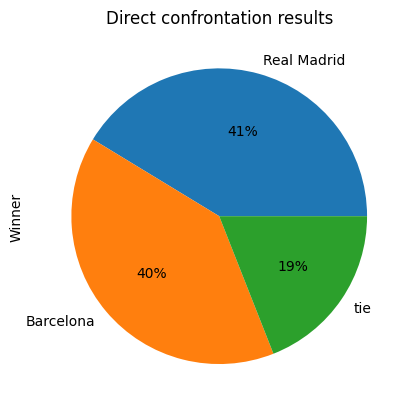

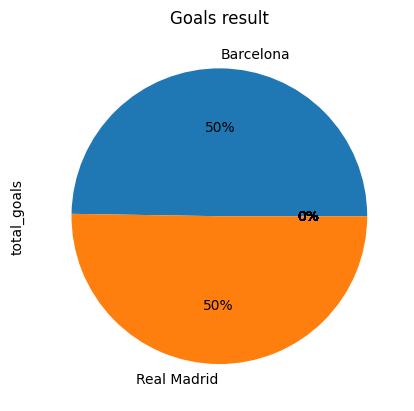

In [17]:
Plot_direct_confrontation_stats('Barcelona', 'Real Madrid')

To analyse the direct confrontations of two teams, the function Plot_direct_confrontation_stats is defined with two imputs corresponding to the normbres of the two opposing teams. This function is divided into two parts: the first one produces a graph with the percentage of matches won by each team as well as the percentage of drawn matches. The second part produces a similar graph but with the goals (in percentage) scored by each team.

The graphs shown are for the Barcelona vs. Real Madrid matches, although this same function can be used for any confrontation between teams belonging to the same division.


6. Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games
without losing. That was, by far, the longest undefeated streak in their history. Which teams have had the longest undefeated streaks? Show the
longest undefeated streaks in a horizontal bar plot, indicating in each bar
the team name and the dates it held that streak, for instance, Real Sociedad
22/04/1979 - 04/05/1980.

In [ ]:
streaks_dic = {}
team_lst = df["home_team"].unique()

for team in team_lst:
    current_streak = 0
    max_streak = 0
    home_games = df2[df2["home_team"] == team]
    away_games = df2[df2["away_team"] == team]
    total_games = pd.concat([home_games, away_games])
    sorted_games = total_games.sort_values(by = "date")
    for index, row in sorted_games.iterrows():
        no_loss = (team == row["home_team"] and row["goal diff"] > -1) or (team == row["away_team"] and row["goal diff"] < 1)
        if no_loss == True:
            current_streak += 1
            if current_streak > max_streak:
                end_date = row["date"]
        else:
            if current_streak > max_streak:
                max_streak = current_streak
                true_st_date = st_date
            current_streak = 0
        if current_streak == 0:
            st_date = row["date"]
    if max_streak == 0:
        streaks_dic[team] = [max_streak, "NA", "NA"]
    else:
        streaks_dic[team] = [max_streak, datetime.strftime(true_st_date, '%d/%m/%Y'), datetime.strftime(end_date, '%d/%m/%Y')]

sorted_streaks = dict(sorted(streaks_dic.items(), key=lambda item: item[1], reverse = True))

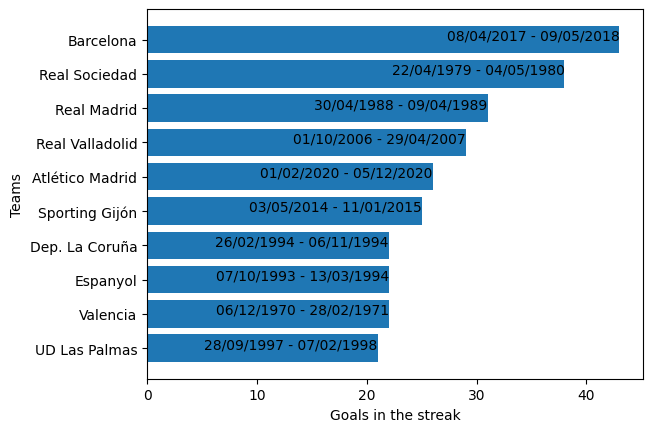

In [ ]:
top10_streaks = {}
top10_teams = []
top10_goals = []
top10_dates = []
for key in sorted_streaks:
    team_data = sorted_streaks[key]
    top10_streaks[key] = team_data
    top10_teams.append(key)
    top10_goals.append(team_data[0])
    top10_dates.append(f"{team_data[1]} - {team_data[2]}")
    if len(top10_streaks) > 9:
        break

plt.figure()
plt.barh(top10_teams, top10_goals)
plt.gca().invert_yaxis()
plt.ylabel('Teams')
plt.xlabel('Goals in the streak')
for x, y, l in zip(top10_goals, top10_teams, top10_dates):
    plt.text(x, y, l, ha = 'right')

In this exercise, all data containing the specified team is split, and it is iterated over to see how many consecutive wins this team has. Afterwards, the initial and ending date is saved, and the result is plotted in a horizontal plot bar, with the initial and ending dates ploted inside. We can see that the longest streak is hold by Barcelona, with over 40 consecurive wins between 2017 and 2018 (more than a year without losing).

7. Create a table with the final standings of each season (and division), that
is, a table that contains all the teams ordered (in descending order) by the
number of points they got during that season, and some other aggregate
statistics. The table must contain the following columns: season, division,
ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals
difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember that, in football, you earn 3 points per victory, and 1 point per tie (none
for loses). In case two teams have same number of points, order by GD (descending), and then by GF (also descending). Order the table so that standings of one season come before standings of previous one, and standings of
1st division come before standings of 2nd division. Save the final table in Excel with the name SeasonStandings.xlsx in the
reports/ folder.


In [119]:
df_agrupada = df2.groupby(["season", "division"])["home_team"].apply(lambda x: pd.unique(x))

In [120]:
def Home_team_stats(season, home_team):
    """Array with the information needed for the table
    args:
        home_team (str) and season (str): string with the name of the confrontated teams and season of the results to make the table from (format: 'aaaa-aaaa').
    returns:
        direct_confrontation_count.plot (pie chart) and scored_goals[].sort_values().plot(pie)
    """
    resultados = df2[(df2.season == season) & (df2.home_team == home_team)]
    partidos_jugados = resultados["home_goals"].count()
    Loses = sum(resultados["Who_Wins"] == 'Visitor win')
    Wins = sum(resultados["Who_Wins"] == 'Home win')
    Ties = sum(resultados["Who_Wins"] == 'Tie')
    points = Ties + 3*Wins
    Scored_goals = resultados["home_goals"].sum().astype(int)
    Conceded_goals = resultados["away_goals"].sum().astype(int)
    goals_diff = Scored_goals - Conceded_goals
    return np.array([partidos_jugados, points, Wins, Loses, Ties, Scored_goals, Conceded_goals, goals_diff])     
    

In [122]:
def Away_team_stats(season, away_team):
    """Array with the information needed for the table
    args:
        away_team (str) and season (str): string with the name of the confrontated teams and season of the results to make the table from (format: 'aaaa-aaaa').
    returns:
        direct_confrontation_count.plot (pie chart) and scored_goals[].sort_values().plot(pie)
    """
    resultados = df2[(df2.season == season) & (df2.away_team == away_team)]
    partidos_jugados = resultados["home_goals"].count()
    Wins = sum(resultados["Who_Wins"] == 'Visitor win')
    Loses = sum(resultados["Who_Wins"] == 'Home win')
    Ties = sum(resultados["Who_Wins"] == 'Tie')
    points = Ties + 3*Wins
    Scored_goals = resultados["away_goals"].sum().astype(int)
    Conceded_goals = resultados["home_goals"].sum().astype(int)
    goals_diff = Scored_goals - Conceded_goals
    return np.array([partidos_jugados, points, Wins, Loses, Ties, Scored_goals, Conceded_goals, goals_diff])

In [123]:
def Season_team(season, team):
    return Home_team_stats(season, team) + Away_team_stats(season,team)

In [124]:
ranking = []
for season in df2.season.unique():
    equipos_1 = df2[(df2.season == season) & (df2.division == 1)]["home_team"].unique() 
    resultados_1 = {x: Season_team(season, x) for x in equipos_1}
    df_season = pd.DataFrame.from_dict(data = resultados_1, orient ='index', columns= ['partidos_jugados', 'points', 'Wins', 'Loses', 'Ties', 'Scored_goals', 'Conceded_goals', 'goals_diff'])
    df_season['season']=season
    df_season['division'] = 1
    df_season = df_season.sort_values(by= ['points','goals_diff', 'Scored_goals'], ascending = False)
    df_season['ranking'] = range(1, len(equipos_1)+1)
    ranking.append(df_season)
    equipos_2 = df2[(df2.season == season) & (df2.division == 2)]["home_team"].unique() 
    resultados_2 = {x: Season_team(season, x) for x in equipos_2}
    df_season = pd.DataFrame.from_dict(data = resultados_2, orient ='index', columns= ['partidos_jugados', 'points', 'Wins', 'Loses', 'Ties', 'Scored_goals', 'Conceded_goals', 'goals_diff'])
    df_season['season']=season
    df_season['division'] = 2
    df_season = df_season.sort_values(by= ['points','goals_diff', 'Scored_goals'], ascending = False)
    df_season['ranking'] = range(1, len(equipos_2)+1)
    ranking.append(df_season)
   


In [125]:
pd.concat(ranking)
SeasonStanding = pd.DataFrame(pd.concat(ranking))
SeasonStanding = SeasonStanding[['season', 'division', 'points', 'ranking', 'Wins', 'Loses', 'Ties', 'Scored_goals','Conceded_goals', 'goals_diff']]
SeasonStanding = SeasonStanding.rename_axis("team").reset_index()

SeasonStanding.to_excel('../reports/SeasonStandings.xlsx', sheet_name='ranking', index = False)

In this exercise you get a one-page excel table with the ranking of all seasons separated by division. The seasons are shown in descending order, i.e. from the oldest to the most recent. For this, two functions are created, one for the home team and one for the away team, where all the necessary data per team is calculated and stored as an array. This data is merged into the function Season_team and the ranking is compiled and exported in the next code box.


8. Villarreal is a team that has grown a lot in recent decades. Specially ever
since some billionaire guy bought it (Fernando Roig, from Mercadona).
Make a line plot showing the rank of Villarreal at the end of each season,
from the oldest ones (left) to the earliest ones (right). Consider rankings in
2nd division to be a continuation of the 1st one, that is, if there’s N teams in
1st division and Villarreal got r position in 2nd division, then it should be
placed in N + r. Draw in the same plot a line showing the cut between 1st
and 2nd division.
Write a function that, given n team names, plots the graph described above
of each one of them superposed. Function prototype should be like plot_ranking_evolution(team1, team2, ..., teamN) and return the plot object (note that function should not take one array-type argument, but n arguments). Use it to compare the evolution of all the teams that currently play in 1st division.

In [52]:
div1_nteams = {}
seasons_list = []
div1_counter = 0
gen_counter = -1

for index, row in SeasonStanding.iterrows():
    gen_counter += 1
    season = row["season"]
    if season in div1_nteams:
        continue
    else:
        if div1_counter > 0 and season != old_season:
            div1_nteams[old_season] = div1_counter
            div1_counter = 1
            old_season = row["season"]
            continue
        elif gen_counter == SeasonStanding.tail(1).index:
            div1_counter += 1
            div1_nteams[old_season] = div1_counter
    if row["division"] != 1:
        div1_nteams[season] = div1_counter
        div1_counter = 0
        continue
    div1_counter += 1
    old_season = row["season"]

In [62]:
def ranking_results(*teams):
    """ Plotting function of the rankings given the name/-s of the team/-s.
    It includes a dashed line with the current division between 1st and 2nd division.

    Args:
        teams (iterator): string or strings of the team's names.
    """
    res_dic = {}
    gen_ses_list = []
    fig, ax = plt.subplots()
    gen_dic = {}
    for team in teams:
        df = SeasonStanding[SeasonStanding['team'] == team]
        seasons_lst = []
        ranking_lst = []
        div1_teams_season = []
        for index, row in df.iterrows():
            season = row["season"]
            seasons_lst.append(season)
            if row["division"] == 1:
                ranking_lst.append(row["ranking"])
            else:
                ranking_lst.append(row["ranking"] + div1_nteams[season])
        gen_dic[team] = [seasons_lst, ranking_lst]
        gen_ses_list.extend(x for x in seasons_lst if x not in gen_ses_list)
    gen_ses_list.sort(key=lambda x: int(x[:4]), reverse= True)
    div1_teams_season = [div1_nteams[x] for x in gen_ses_list]
    ax.plot(gen_ses_list, div1_teams_season, label = "1st and 2nd Division separation line", linestyle = 'dashed')
    for team in teams:
        ax.plot(gen_dic[team][0], gen_dic[team][1], label = team)
    ax.set_xlabel('Seasons')
    ax.set_ylabel('Ranking')
    plt.xticks(np.arange(0, len(gen_ses_list)+1, len(gen_ses_list)/10 + 1))
    plt.xticks(rotation=30)
    ax.invert_xaxis()
    ax.set_title("Team(s) ranking over time")
    ax.legend()
    ax.get_lines()[0]
    plt.show()

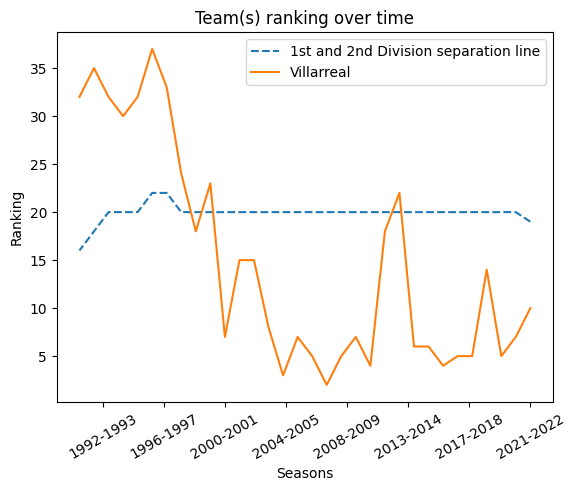

In [63]:
ranking_results("Villarreal")

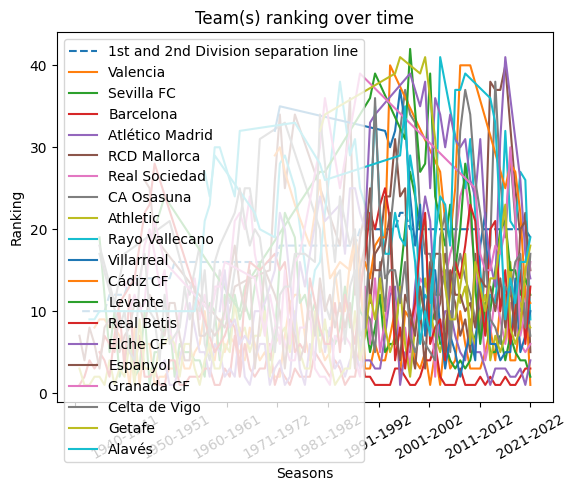

In [64]:
df = SeasonStanding.loc[(SeasonStanding["season"] == "2021-2022") & (SeasonStanding["division"] == 1)]
teams_list = list(df["team"])
ranking_results(*teams_list)

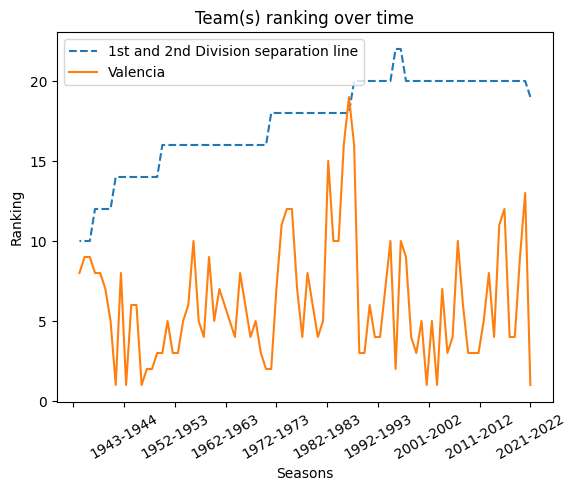

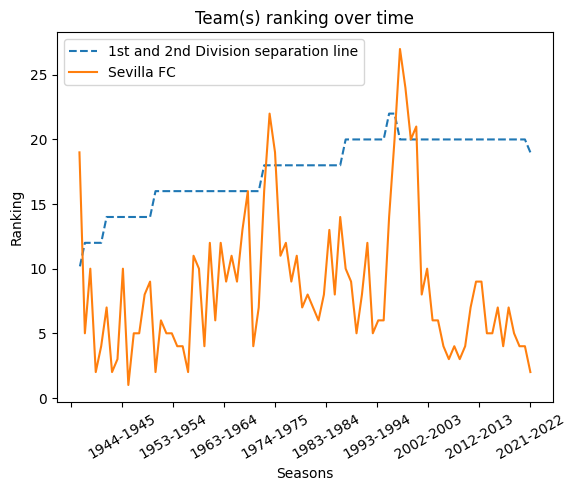

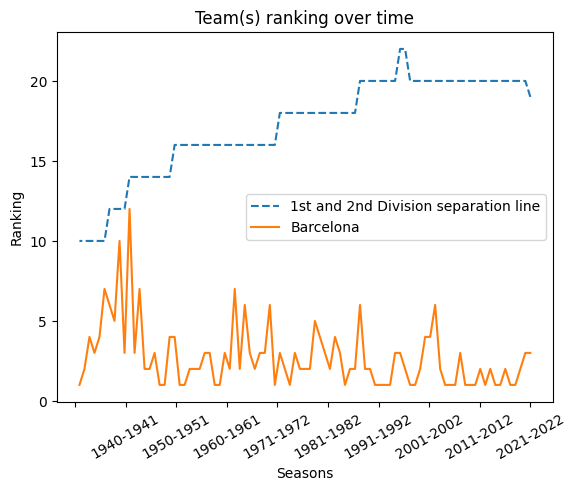

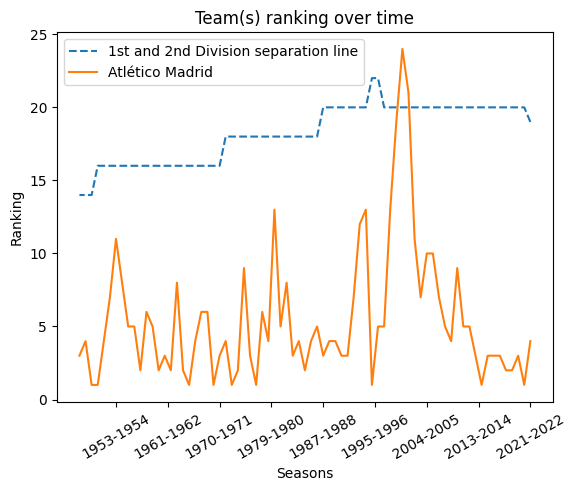

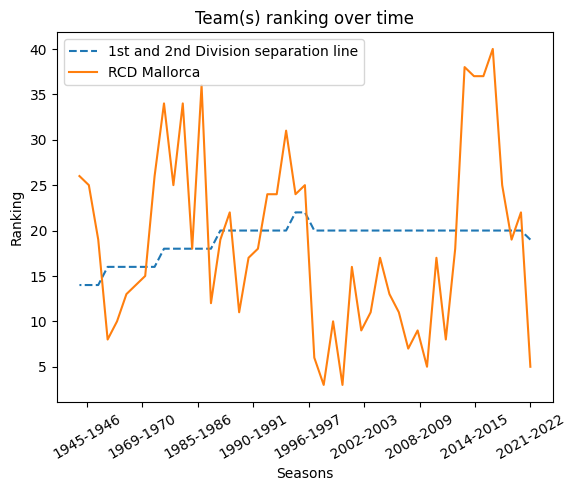

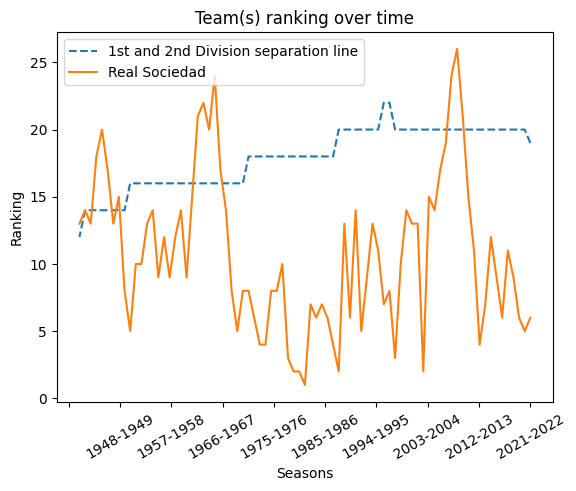

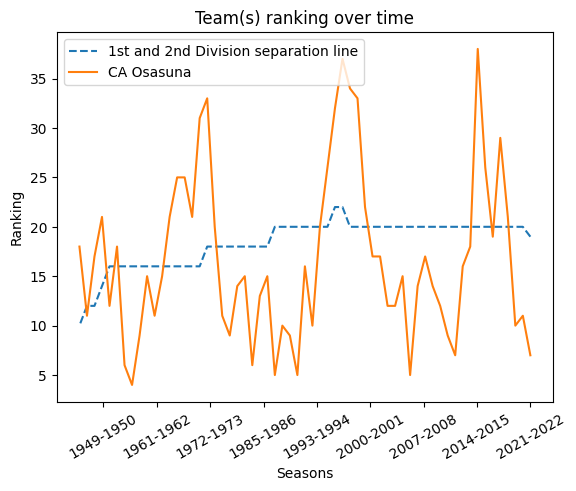

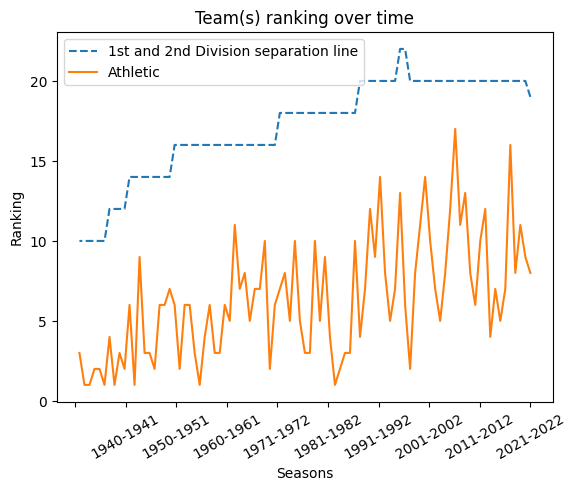

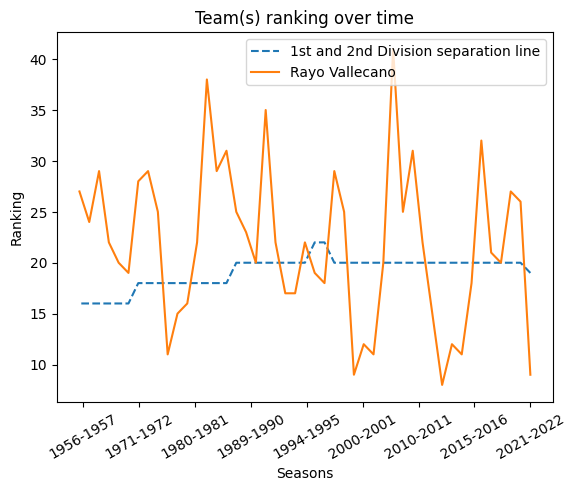

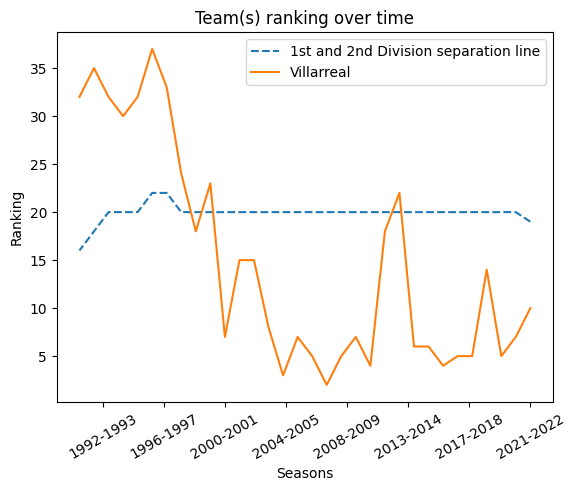

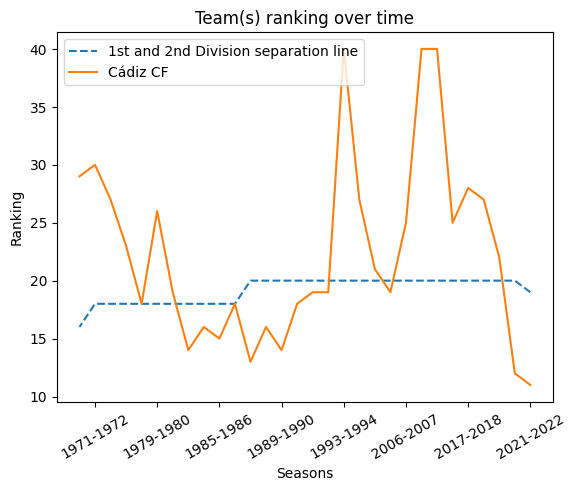

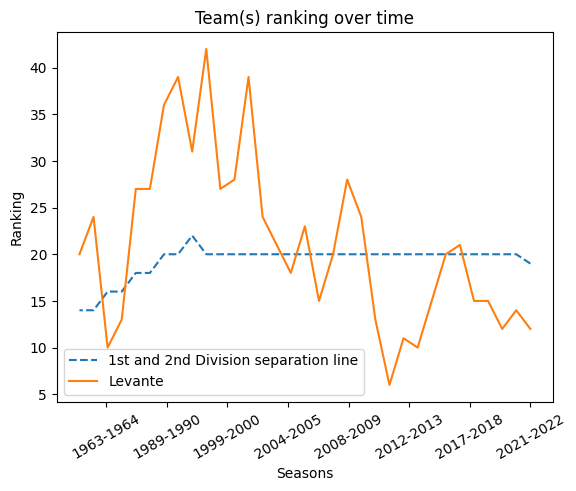

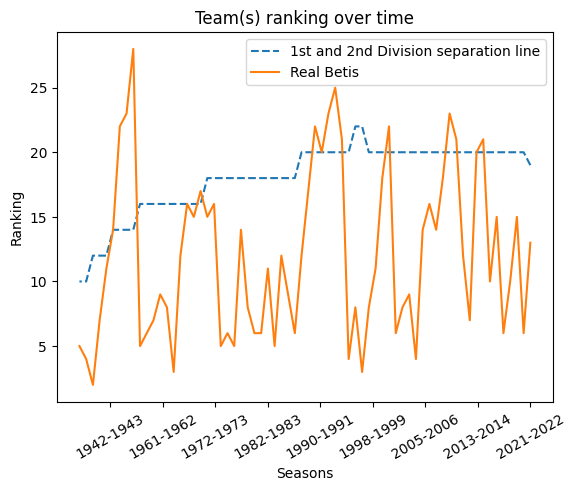

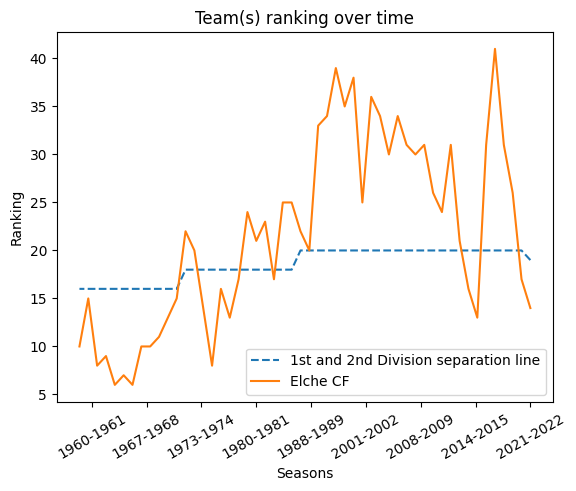

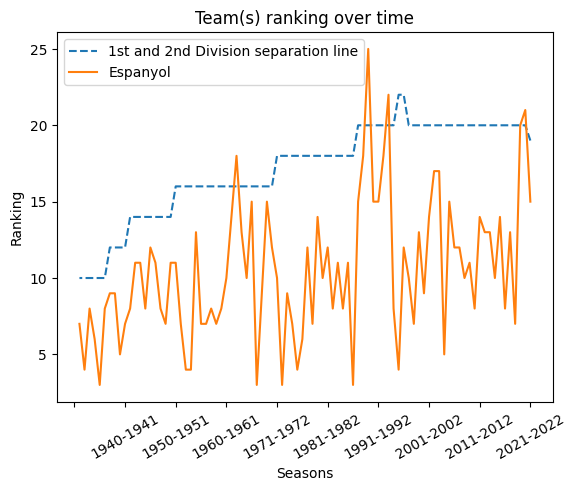

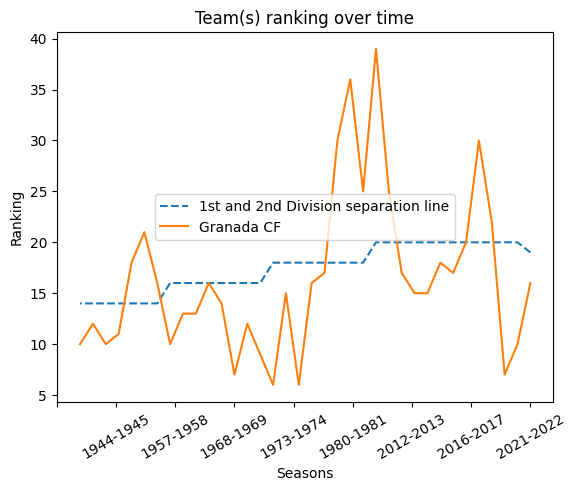

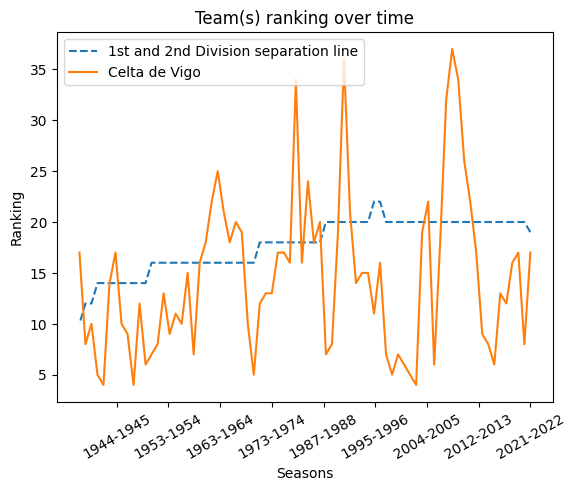

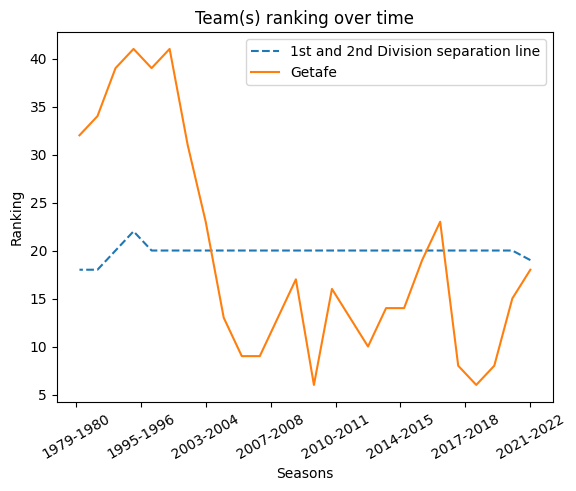

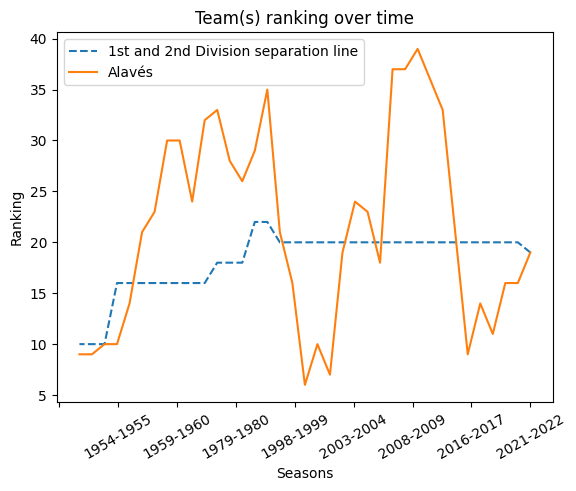

In [65]:
for team in teams_list:
    ranking_results(team)

Results are obtained for Villareal, as well as all the teams currently in 1st division (season 2021-2022). The results for all teams in 1st division is presented together (which produces a very messy plot), and independently for each plot.

Info about the function:
    Plotting function of the rankings given the name/-s of the team/-s.
    It includes a dashed line with the current division between 1st and 2nd division.

    Args:
        teams (iterator): string or strings of the team's names.

9. In football jargon, those teams that are permanently descending and ascending between 1st and 2nd division are called elevator teams. What are the most elevator teams in LaLiga? Plot the history of the top 5 of them using the function from exercise 8.

Team: Dep. La Coruña; Elevator counter = 20
Team: Racing; Elevator counter = 17
Team: Celta de Vigo; Elevator counter = 17
Team: Rayo Vallecano; Elevator counter = 15
Team: Real Betis; Elevator counter = 14


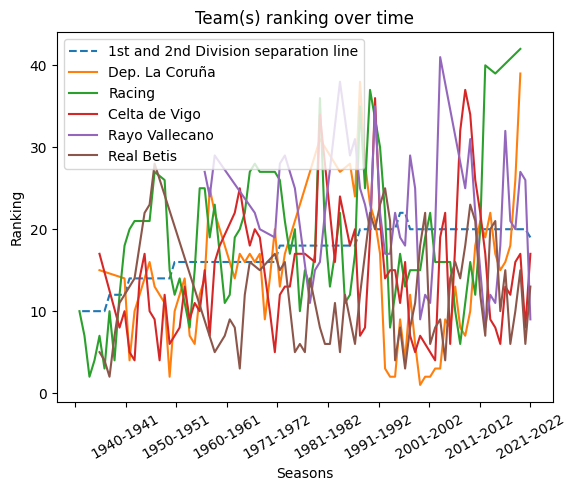

In [66]:
sub_df = SeasonStanding[["team","division"]]
unique_teams = sub_df["team"].unique()
values_dic = {}
pivot = pd.pivot_table(SeasonStanding, values="division" , index="season", columns = "team")
for team in unique_teams:
    data = pivot[team]
    full_data = data.dropna()
    counter = 0
    for elem in full_data:
        if counter == 0:
            prev_elem = elem
            counter += 1
        if elem == prev_elem:
            continue
        else:
            prev_elem = elem
            counter += 1
    counter -= 1
    values_dic[team] = counter
top_elevator = list(dict(sorted(values_dic.items(), key=lambda item: item[1], reverse = True)).keys())
top5_elevator = top_elevator[:5]
for team in top5_elevator:
    print(f"Team: {team}; Elevator counter = {values_dic[team]}")
ranking_results(*top5_elevator)

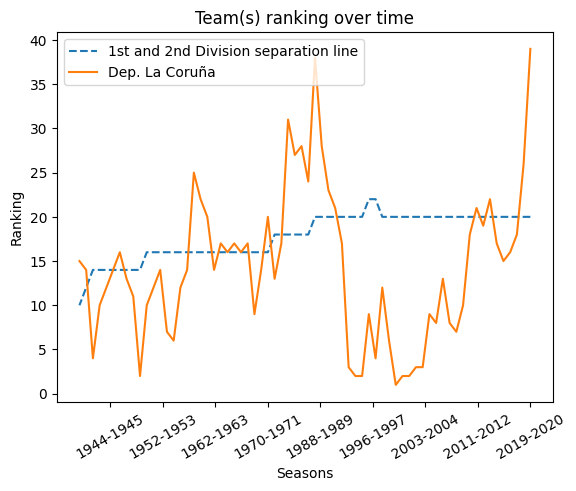

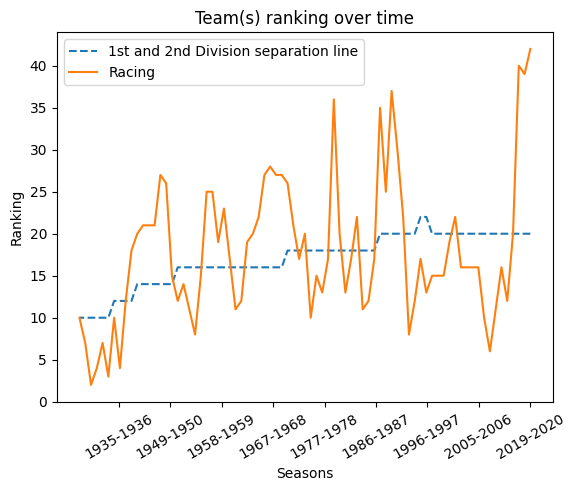

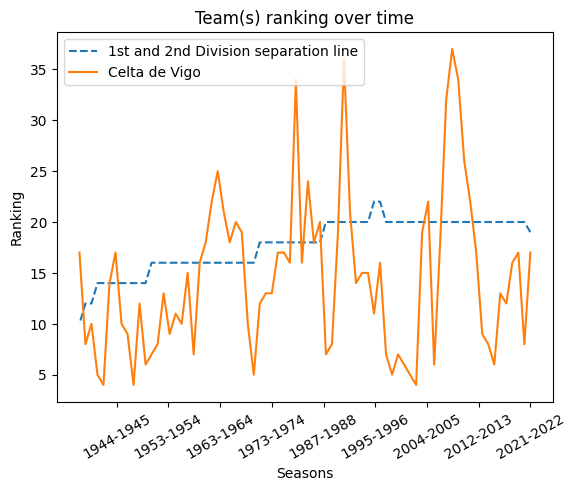

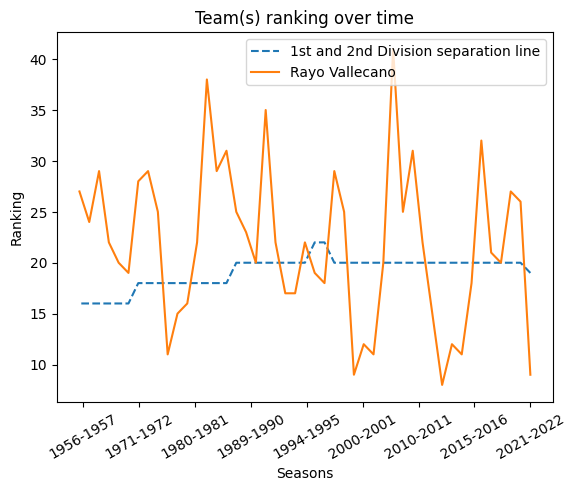

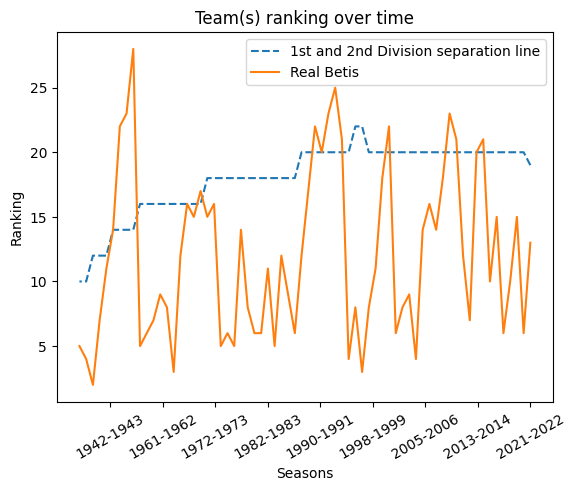

In [67]:
for team in top5_elevator:
    ranking_results(team)

In this case, a pivot table is created to obtain the history of the different divisions the teams have been in. Afterwards, this history is iterated over to count how many times there has been a jump from one division to another. Finally, these results are plotted using the same function as the last exercise.

10. Create a table that is the same as the one in exercise 7, but not only with
the season final standings, but the standings at the end of each matchday.
Columns are the same, including matchday that tells about which match-day from the season these standings are from. Would you be able to add a
new column last_5 with the result of last 5 matches? This column should
contain a list like ["W", "L", "W", "T", "T"]. In this list, the first item is
the immediate previous match, the second one is the match before this one,
and so on. If there are no 5 previous matches (because matchday < 6, for
instance) then just make the list shorter.
Save the final table in Excel with the name MatchdayStandings.xlsx in the
reports/ folder.

In [94]:
df_agrupada2 = df2.groupby(["season", "division","matchday"])["home_team"].apply(lambda x: pd.unique(x))
df_agrupada2


season     division  matchday
1928-1929  1         1           [Arenas Club, Espanyol, Real Madrid, Donostia,...
                     2           [Barcelona, Athletic, Athletic Madrid, Real Un...
                     3           [Donostia, Espanyol, Arenas Club, Racing, Real...
                     4           [Real Unión, Real Madrid, Espanyol, Barcelona,...
                     5           [Catalunya, Athletic Madrid, Racing, Donostia,...
                                                       ...                        
2021-2022  1         2           [Real Betis, Alavés, Granada CF, Espanyol, Ath...
                     3           [RCD Mallorca, Valencia, Celta de Vigo, Real S...
           2         1           [SD Huesca, Real Zaragoza, Real Sociedad B, Gi...
                     2           [Real Valladolid, UD Almería, CD Lugo, CD Tene...
                     3           [UD Las Palmas, Málaga CF, Sporting Gijón, CD ...
Name: home_team, Length: 5168, dtype: object

In [95]:
#local points
df2[(df2.season == '2000-2001') & (df2.matchday == 1) & (df2.home_team == 'Real Madrid')]['Who_Wins'].value_counts().values

array([1])

In [96]:
#Home scored goals-
df2[(df2.season =='1928-1929') & (df2.matchday == 1) & (df2.home_team == 'Real Madrid')]["home_goals"].sum().astype(int)


5

In [97]:
dic1 = defaultdict(dict)

def Home_team_matchday(season, matchday,  home_team):
    resultados = df2[(df2.season == season) & (df2.matchday == matchday) & (df2.home_team == home_team)]
    partidos_jugados = resultados["home_goals"].count()
    Loses = sum(resultados["Who_Wins"] == 'Visitor win')
    Wins = sum(resultados["Who_Wins"] == 'Home win')
    Ties = sum(resultados["Who_Wins"] == 'Tie')
    W = (resultados["Who_Wins"] == 'Home win')
    L = (resultados["Who_Wins"] == 'Visitor win')
    T = (resultados["Who_Wins"] == 'Tie')
    try:
        if Loses:
            dic1[season][home_team].append('L') 
        if Wins:
            dic1[season][home_team].append('W') 
        else: dic1[season][home_team].append('T') 
    except KeyError:
        if Loses:
            dic1[season][home_team] = ['L']
        if Wins:
            dic1[season][home_team] = ['W']
        else:
            dic1[season][home_team] = ['T']

    
    
    points = Ties + 3*Wins
    Scored_goals = resultados["home_goals"].sum().astype(int)
    Conceded_goals = resultados["away_goals"].sum().astype(int)
    goals_diff = Scored_goals - Conceded_goals
    return np.array([partidos_jugados, points, Wins, Loses, Ties, Scored_goals, Conceded_goals, goals_diff])


In [98]:
Home_team_matchday('2000-2001', 1, 'Alavés')

array([0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
def Away_team_matchday(season, matchday, away_team):
    resultado = df2[(df2.season == season) & (df2.matchday == matchday) & (df2.away_team == away_team)]
    partidos_jugados = resultado["home_goals"].count()
    Wins = sum(resultado["Who_Wins"] == 'Visitor win')
    Loses = sum(resultado["Who_Wins"] == 'Home win')
    Ties = sum(resultado["Who_Wins"] == 'Tie')
    W = (resultado["Who_Wins"] == 'Visitor win')
    L = (resultado["Who_Wins"] == 'Home win')
    T = (resultado["Who_Wins"] == 'Tie')
    try:
        if Loses:
            dic1[season][away_team].append('L') 
        if Wins:
            dic1[season][away_team].append('W') 
        else: dic1[season][away_team].append('T') 
    except KeyError:
        if Loses:
            dic1[season][away_team] = ['L']
        if Wins:
            dic1[season][away_team] = ['W']
        else:
            dic1[season][away_team] = ['T']
    
    points = Ties + 3*Wins
    Scored_goals = resultado["away_goals"].sum().astype(int)
    Conceded_goals = resultado["home_goals"].sum().astype(int)
    goals_diff = Scored_goals - Conceded_goals
    return np.array([partidos_jugados, points, Wins, Loses, Ties, Scored_goals, Conceded_goals, goals_diff])

In [100]:
def Matchday_team(season, matchday, team):
    return Home_team_matchday(season, matchday,  team) + Away_team_matchday(season, matchday, team)


In [111]:
def Last_5(season, matchday, team, dic1):
    try: 
        dic1[team][0]
        if len(dic1[team]) > 0 and len(dic1[team]) < 6:
            red_list = dic1[team][:-1]
            rev_list = list(reversed(red_list))
            Last_5_str = ",".join(rev_list)
        else:
            red_list = dic1[team][-6:-1]
            rev_list = list(reversed(red_list))
            Last_5_str = ",".join(rev_list)
    except KeyError:
        Last_5_str = ""
    return(Last_5_str)

In [115]:
ranking_matchday = []
test_seasons = ["2021-2022"]

#for season in df2.season.unique()[::-1]:
for season in test_seasons:
    df_transicion = df2[df2.season == season]    
    df_transicion.sort_values("matchday")
    
    print(season)
    for matchday in df_transicion.matchday:
        
        
        equipos_1 = df_transicion[(df_transicion.season == season) & (df_transicion.matchday == matchday) & (df_transicion.division == 1)]["home_team"].unique() 
        resultados_1 = {x: Matchday_team(season, matchday, x) for x in equipos_1}
        last_5 = {x: Last_5(season, matchday, x, dic1) for x in equipos_1}
        df_matchday = pd.DataFrame.from_dict(data = resultados_1, orient ='index', columns= ['partidos_jugados', 'points', 'Wins', 'Loses', 'Ties', 'Scored_goals', 'Conceded_goals', 'goals_diff'])
        df_matchday['season']=season
        df_matchday['division'] = 1
        df_matchday['matchday'] = matchday
        df_matchday['Last_5'] = last_5
        df_matchday = df_matchday.sort_values(by= ['points','goals_diff', 'Scored_goals'], ascending = False)
        df_matchday['ranking'] = range(1, len(equipos_1)+1)
        ranking_matchday.append(df_matchday)
        equipos_2 = df_transicion[(df_transicion.season == season) & (df_transicion.matchday == matchday) & (df_transicion.division == 1)]["home_team"].unique() 
        resultados_2 = {x: Matchday_team(season, matchday, x) for x in equipos_2}
        last_5 = {x: Last_5(season, matchday, x, dic1) for x in equipos_2}
        df_matchday = pd.DataFrame.from_dict(data = resultados_2, orient ='index', columns= ['partidos_jugados', 'points', 'Wins', 'Loses', 'Ties', 'Scored_goals', 'Conceded_goals', 'goals_diff'])
        df_matchday['season']=season
        df_matchday['division'] = 2
        df_matchday['matchday'] = matchday
        df_matchday = df_matchday.sort_values(by= ['points','goals_diff', 'Scored_goals'], ascending = False)
        df_matchday['ranking'] = range(1, len(equipos_1)+1)
        ranking_matchday.append(df_matchday)

2021-2022


In [118]:
pd.concat(ranking_matchday)
MatchdayStanding = pd.DataFrame(pd.concat(ranking_matchday))
MatchdayStanding = MatchdayStanding[['season', 'division', 'matchday', 'points', 'ranking', 'Wins', 'Loses', 'Ties', 'Scored_goals','Conceded_goals', 'goals_diff']]
MatchdayStanding.to_excel('../reports/Matchdaystanding.xlsx', sheet_name='ranking', index = False)

Finally, in this exercise 10 we take advantage of the functions defined in exercise 7 for the team playing at home and for the away team and we also create two dictionaries where three variables are related: the season, the matchday and the team. With this dictionary, a function is created to store the information of the last five matches of the team. Finally, a ranking is created, as in exercise 7, but instead of by season and division, by season, division and matchday.

These results are exported in a single page excel table.

**Sadly, this exercise does not render the correct result, even though we have tried together for some hours**

## Additional code to build the ranking feature:

In [ ]:
rank_goals = defaultdict(dict)

list_teams = SeasonStanding["team"].unique()
teams_codif_dic = {}
all_data = {}
counter = 0
for team in list_teams:
    teams_codif_dic[team] = counter
    counter += 1

for index, row in SeasonStanding.iterrows():
    team = row["team"]
    season = row["season"]
    if row["division"] == 1:
        real_ranking = row["ranking"]
    else:
        real_ranking = row["ranking"] + div1_nteams[season]
    rank_goals[season][team] = [real_ranking, row["goals_diff"]]
all_data["teams_codif"] = teams_codif_dic
all_data["seasonal_data"] = rank_goals

all_data = dict(all_data)
with open("../feature_data.json", "w") as outfile:
    json.dump(all_data, outfile)